# 读取Micaps数据文件格式

#### —— nmc_met_io程序库使用说明

国家气象中心天气预报技术研发室    
June, 2020    
Kan Dai 

## Prepare

In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load libraries
import numpy as np
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import StationPlot, sky_cover
from metpy.units import units

from nmc_met_io.read_micaps import read_micaps_1
from nmc_met_graphics.plot.china_map import add_china_map_2cartopy

## 读取第1类 地面全要素填图数据

* 此类数据用于规范的地面填图
* 文件头：diamond  1  数据说明（字符串）  年  月  日  时次  总站点数（均为整数）
* 数据：  
  - 区站号（长整数）  经度  纬度  拔海高度（均为浮点数）站点级别（整数）  总云量  风向  风速  海平面气压（或本站气压）  3小时变压  过去天气1  过去天气2  6小时降水 低云状  低云量  低云高  露点  能见度  现在天气  温度 中云状  高云状  标志1  标志2（均为整数） 24小时变温  24小时变压
 - 缺值时用9999表示，以后相同。
 - 站点级别表示站点的放大级别，即只有当图象放大到该级别时此站才被填图。以后相同。
 - 当标志1为1，标志2为2时，说明后面有24小时变温变压。否则说明后面没有24小时变温变压。

In [3]:
filename = "samples/micaps/surface_plot/20032714.000"
data = read_micaps_1(filename)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6644 entries, 0 to 6643
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 6644 non-null   object        
 1   lon                6644 non-null   float64       
 2   lat                6644 non-null   float64       
 3   alt                6106 non-null   float64       
 4   grade              6644 non-null   int64         
 5   total_cloud_cover  3978 non-null   float64       
 6   wind_angle         6644 non-null   int64         
 7   wind_speed         6644 non-null   int64         
 8   MSLP               4570 non-null   float64       
 9   pressure_3h_trend  4454 non-null   float64       
 10  past_weather_1     6644 non-null   int64         
 11  past_weather_2     6644 non-null   int64         
 12  precipitation_6h   305 non-null    float64       
 13  low_cloud_type     1289 non-null   float64       
 14  low_clou

In [4]:
# 将风和总云量缺测的观测去除
data = data.dropna(how='any', subset=['total_cloud_cover', 'wind_angle', 'wind_speed'])

# 降低观测数据的空间密度, 防止站点之间相互遮挡
proj = ccrs.LambertConformal(central_longitude=-98)
point_locs = proj.transform_points(ccrs.PlateCarree(), data['lon'].values, data['lat'].values)
data = data[mpcalc.reduce_point_density(point_locs, 80 * units.km)]

In [5]:
# prepare the data for Metpy station plot
temperature = data['temperature'].values
dewpoint = data['dewpoint'].values
pressure = data['MSLP'].values * units.hPa
cloud_coverage = np.array(data['total_cloud_cover'].values, dtype=int)
wind_speed = data['wind_speed'].values * units.meter_per_second
wind_direction = data['wind_angle'].values * units.deg
latitude = data['lat']
longitude = data['lon']

# Take cardinal direction and convert to degrees, then convert to components
u, v = mpcalc.wind_components(wind_speed.to('knots'), wind_direction)

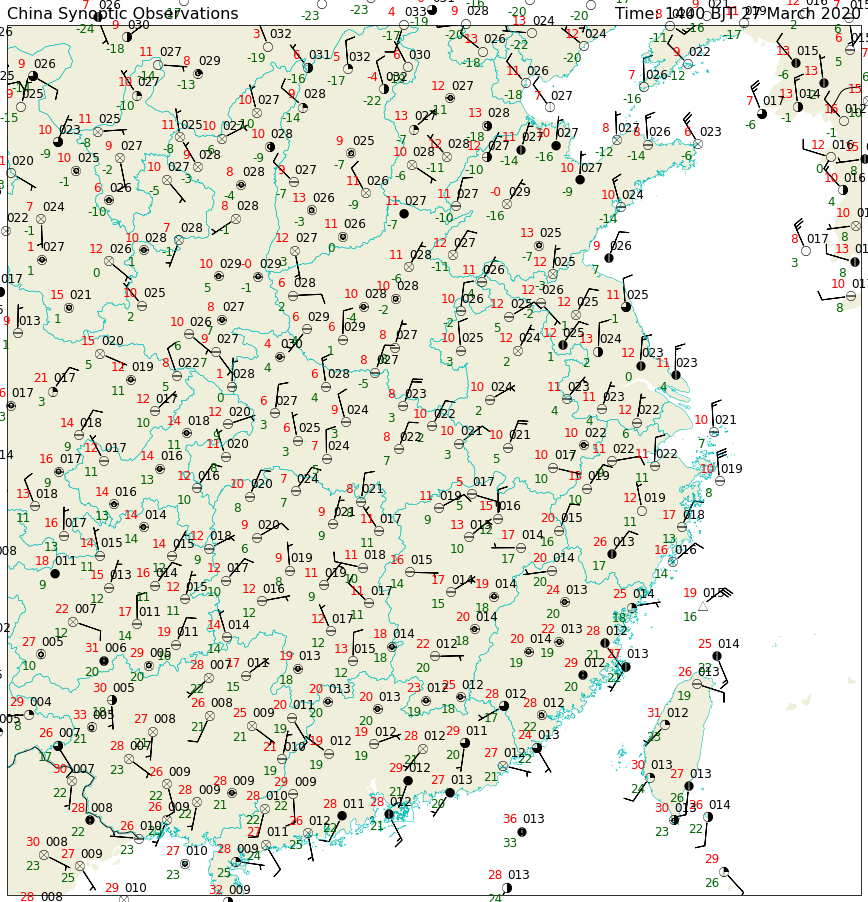

In [6]:
# Create the figure and an axes set to the projection.
proj = ccrs.LambertConformal(central_longitude=115)
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)
add_china_map_2cartopy(ax, lw=0.5)

# Set plot bounds
ax.set_extent((105, 125, 20, 40))

stationplot = StationPlot(ax, longitude.values, latitude.values, clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', temperature, color='red')
stationplot.plot_parameter('SW', dewpoint, color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', pressure.m, formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', cloud_coverage, sky_cover, fontsize=10)

# Add wind barbs
stationplot.plot_barb(u, v, sizes={'emptybarb':0.1})

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and -1 in y.
#stationplot.plot_text((2, -1), station_id)

# Add title and display figure
plt.title('China Synoptic Observations', fontsize=16, loc='left')
plt.title('Time: 1400 BJT 27 March 2020', fontsize=16, loc='right')
plt.show()